In [1]:
from freealg import FreeForm
from freealg.distributions import MarchenkoPastur, Wigner, Wachter, Meixner, KestenMcKay
import numpy as np
import numpy
import texplot

latex = True
ext = '.pdf'

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm

#x = np.linspace(mp.lam_m-1, mp.lam_p+1, 300)

def decompress_plot(eig, x2, ff, family, save_filename, ylim=None, cutoff=None):
    dims = list(eig.size * 2**numpy.arange(0, 6))# + [45000]
    dims = [int(a) for a in dims]
    
    rho = ff.density(x2, plot=False)
    
    x2_pred = []
    rhos_pred = []
    x2_pred.append(x2)
    rhos_pred.append(rho)
    for i in range(1, len(dims)):
        if cutoff is not None:
            xm = x2[cutoff(dims[i], x2)]
        else:
            xm = x2
        rho_pred, eig_pred = ff.decompress(dims[i], x=xm, plot=False)
        x2_pred.append(xm)
        rhos_pred.append(rho_pred)
    
    lw = 1.5
    
    num_plots = len(dims)
    # cmap = plt.get_cmap('Reds')
    cmap = plt.get_cmap('gist_heat')
    colors = [cmap(i/(num_plots + 2)) for i in range(num_plots + 1)][1:]
    
    with texplot.theme(use_latex=latex):
        
        fig, ax = plt.subplots(figsize=(10, 3.1), ncols=3, sharey=True)
     
        ax[0].plot(x2, rho, linewidth=lw, color='black', label = 'Density Estimate')
        ax[0].hist(eig, bins=25, density=True, color='lightsteelblue', alpha=0.8, edgecolor='none',
                   label='Empirical Spectrum', rasterized=True)
        ax[0].set_title('(a) Initial Empirical Density ($n=1$K)')
    
        for i in range(0, len(dims)):
            ax[1].plot(x2_pred[i], rhos_pred[i], linewidth=lw, color=colors[i], label = f'$n = {{{dims[i]//1000}}}$K')
            
        ax[1].set_title('(b) Free Decompression')
    
        mp2 = family(dims[-1])
        mprho = mp2.density(x2, plot=False)
    
        ax[2].plot(x2, mprho, linewidth=lw, color='black', label = r'Benchmark Density (Exact)')
        ax[2].plot(x2_pred[-1], rhos_pred[-1], linewidth=lw, color=colors[-1], label = 'Free Decompression Solution')
        ax[2].set_title(r'(c) Final Empirical Density ($n=32$K)')
    
        for i in range(len(ax)):
            ax[i].legend(fontsize='x-small')
            ax[i].set_xlabel(r'$\lambda$')
            if ylim is not None:
                ax[i].set_ylim(ylim)
            #ax[i].set_xlim([-0.2, 3.4])
            
        ax[0].set_ylabel(r'Density $\rho(\lambda)$')
    
        for i in range(1, len(ax)):
            ax[i].tick_params(left=False, labelleft=False)
    
        plt.tight_layout()
        texplot.show_or_save_plot(plt, default_filename=save_filename,
                                          transparent_background=True, dpi=200,
                                          show_and_save=True, verbose=True)

### Marchenko-Pastur

Plot saved to "/home/liam/Dropbox (Maestral)/CodeProjects/freealg/flow_mp.pdf".


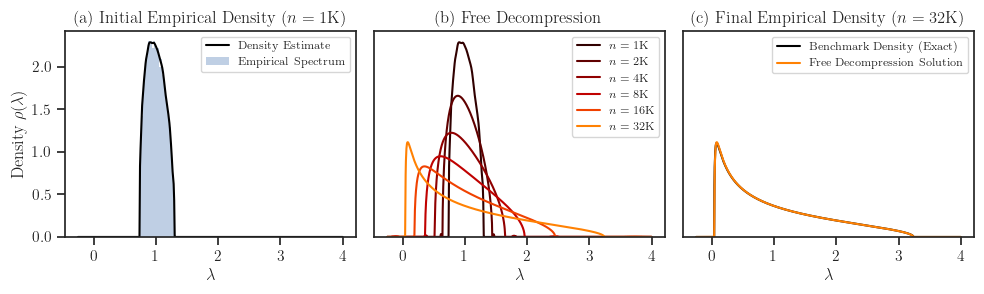

In [22]:
c = 1/50
mp = MarchenkoPastur(c)
A = mp.matrix(1000)
eig = np.linalg.eigvalsh(A)
#eig = mp.sample(1000)

ff = FreeForm(eig, support=(mp.lam_m, mp.lam_p))
psi = ff.fit(method = 'chebyshev', K=50, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.001, damp='jackson',
             force=True, pade_p=0, pade_q=1, odd_side='left', pade_reg=0,
             optimizer='ls', plot=False, latex=latex, save=False)

family = lambda n: MarchenkoPastur((n/1000)/50)
x2 = np.linspace(-0.25, 4, 1000)
save_filename = 'flow_mp'+ext

decompress_plot(eig, x2, ff, family, save_filename)

### Wigner

Plot saved to "/home/sia/work/github/freealg/notebooks/flow_wg.pdf".


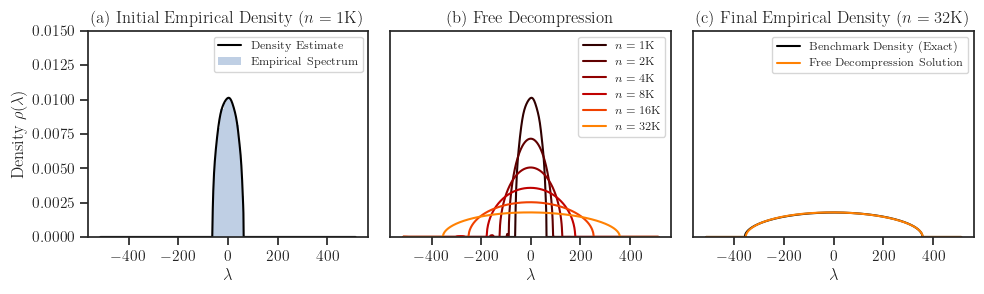

In [5]:
n = 1000
wg = Wigner(2 * numpy.sqrt(n))
A = wg.matrix(n)
eig = np.linalg.eigvalsh(A)
#eig = mp.sample(1000)

ff = FreeForm(eig, support=(wg.lam_m, wg.lam_p))
psi = ff.fit(method = 'chebyshev', K=50, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.01, damp='jackson',
             force=True, pade_p=0, pade_q=1, odd_side='left', pade_reg=0,
             optimizer='ls', plot=False, latex=latex, save=False)

family = lambda n: Wigner(2 * numpy.sqrt(32000))
save_filename = 'flow_wg'+ext
ylim = [0, 0.015]
x2 = np.linspace(-2*66000**0.5, 2*66000**0.5, 1000)

with texplot.theme(use_latex=True):
    decompress_plot(eig, x2, ff, family, save_filename, ylim=ylim)

### Wachter

Plot saved to "/home/liam/Dropbox (Maestral)/CodeProjects/freealg/flow_wa.pdf".


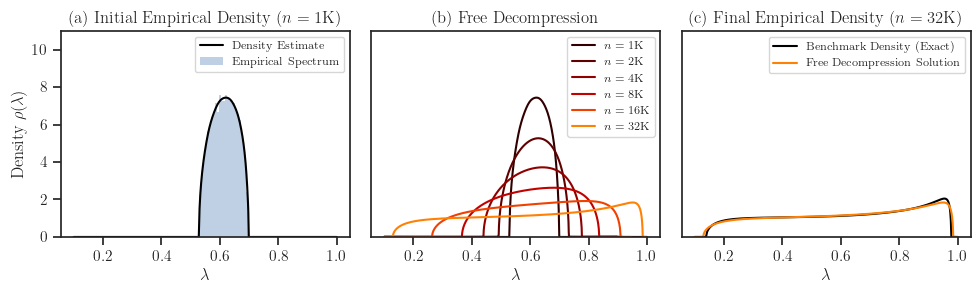

In [28]:
from scipy.linalg import eigh

n = 1000
a, b = 80, 50
wa = Wachter(a, b)
Sx, Sy = wa.matrix(n)
eig = eigh(Sx, Sx+Sy, eigvals_only=True)
#eig = wa.sample(1000)

ff = FreeForm(eig, support=(wa.lam_m, wa.lam_p))
psi = ff.fit(method = 'chebyshev', K=20, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.001, damp='jackson',
             force=True, pade_p=-1, pade_q=2, odd_side='left', pade_reg=0,
             optimizer='de', plot=False, latex=latex, save='wachter_test.png')

family = lambda n: Wachter(a/(n/1000), b/(n/1000))
save_filename = 'flow_wa'+ext
ylim = [0, 11]
x2 = np.linspace(0.1, 1, 1000)
cutoff = lambda n,x: x < 0.89+0.11*n/32000

with texplot.theme(use_latex=True):
    decompress_plot(eig, x2, ff, family, save_filename, ylim=ylim, cutoff=cutoff)

### Kesten-McKay

In [ ]:
n = 32_000
d = 2
km = KestenMcKay(d)
A = km.matrix(n)
eig_all = np.linalg.eigvalsh(A)

In [5]:
ns = 1000
eig = np.linalg.eigvalsh(A[:ns, :ns])

ff = FreeForm(eig) # support=(km.lam_m, km.lam_p))
psi = ff.fit(method = 'chebyshev', K=50, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.01, damp='jackson',
             force=True, pade_p=-1, pade_q=2, odd_side='left', pade_reg=0,
             optimizer='de', plot=False, latex=False, save=False)

Plot saved to "/home/sia/work/github/freealg/notebooks/flow_km.pdf".


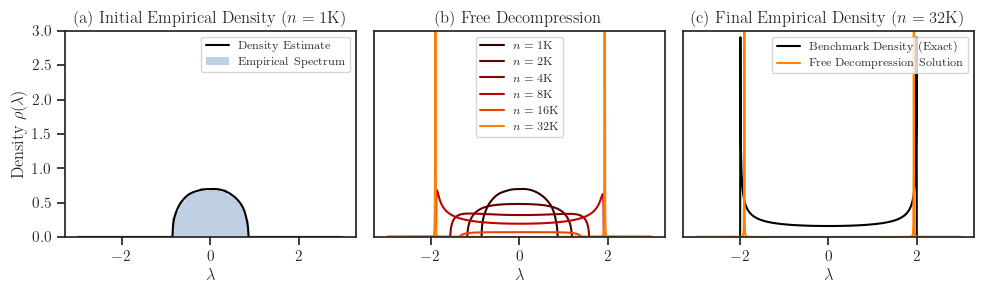

In [8]:
family = lambda n: KestenMcKay(d)
save_filename = 'flow_km'+ext
ylim = [0, 3]
x2 = np.linspace(-3, 3, 1000)

with texplot.theme(use_latex=True):
    decompress_plot(eig, x2, ff, family, save_filename, ylim=ylim)

### Meixner

Plot saved to "/home/liam/Dropbox (Maestral)/CodeProjects/freealg/meixner_test.png".


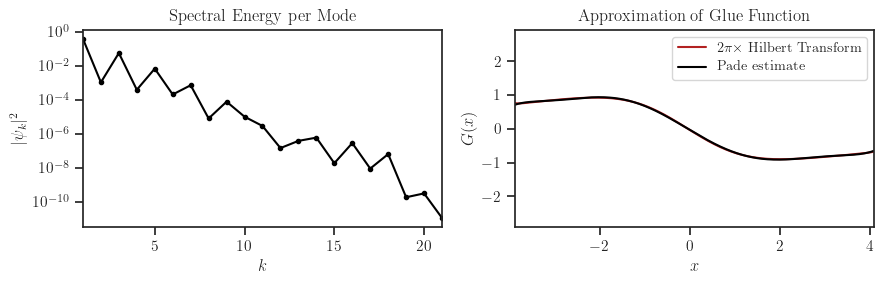

Plot saved to "/home/liam/Dropbox (Maestral)/CodeProjects/freealg/flow_mx.pdf".


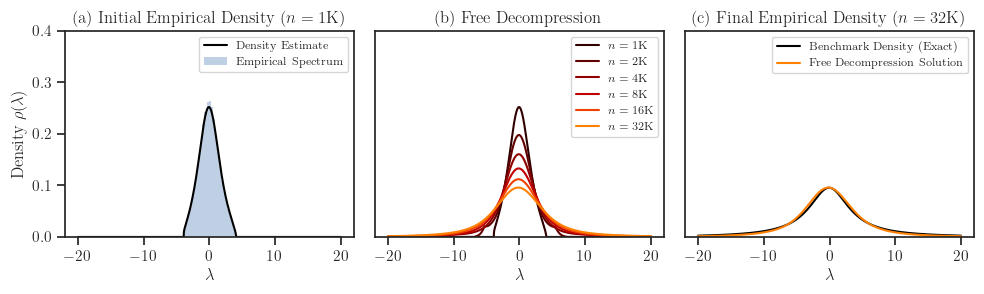

In [30]:

n = 1000
a, b, c = 0.1, 4, 0.6
mx = Meixner(a, b, c)
eig = mx.sample(n)

ff = FreeForm(eig, support=(mx.lam_m, mx.lam_p))
psi = ff.fit(method = 'chebyshev', K=20, alpha=0.5, beta=0.5, reg=0,
             projection='beta', kernel_bw=0.001, damp='jackson',
             force=True, pade_p=-1, pade_q=8, odd_side='left', pade_reg=0,
             optimizer='de', plot=True, latex=latex, save='meixner_test.png')

alpha = lambda n: (n/1000)**0.5
a_prime = lambda n: a * alpha(n)
c_prime = lambda n: c / (c + alpha(n)*(1-c))
b_prime = lambda n: b * alpha(n)**2 * (1 - c_prime(n)) / (1 - c)
family = lambda n: Meixner(a_prime(n), b_prime(n), c_prime(n))
save_filename = 'flow_mx'+ext
ylim = [0, .4]
x2 = np.linspace(-20, 20, 1000)
#cutoff = lambda n,x: x < 0.89+0.11*n/32000

with texplot.theme(use_latex=True):
    decompress_plot(eig, x2, ff, family, save_filename, ylim=ylim)